In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import prince

import gower

%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [3]:
loans = pd.read_csv("data/SBA_clnd.csv")
loans.head()

,Name,City,State,Zip,Bank,BankState,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,CARVEL,APEX,NC,27502,STEARNS BK NATL ASSOC,MN,2006,2,1,0,0,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,SUBWAY,LITTLE ROCK,AR,72223,HOPE FCU,MS,2006,7,0,0,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,WEYLAND CORPORATION,CAMARILLO,CA,93010,WELLS FARGO BANK NATL ASSOC,SD,2006,18,1,5,23,1.0,0.0,438541.0,0,61,0.0,0,6.916667,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,CHICAGO BRICK UNLIMITED INC,MIAMI,FL,33186,"CITIBANK, N.A.",FL,2006,4,0,0,4,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,"RZI, INC.",NEW ORLEANS,LA,70130,BUSINESS RES. CAP. SPECIALTY B,LA,2006,3,0,0,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [4]:
bank_counts = loans["Bank"].value_counts()
loans["bank_size"] = loans["Bank"].apply(lambda x: bank_counts[x])

<IPython.core.display.Javascript object>

In [5]:
drop_cols = [
    "Name",
    "City",
    "Zip",
    "Bank",
    "ApprovalFY",
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
]
loans = loans.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

In [6]:
num_cols = [
    "NoEmp",
    "CreateJob",
    "RetainedJob",
    "DisbursementGross",
    "Term_years",
    "Disbr_year",
    "percent_SBA",
    "bank_size",
]
cat_cols = [
    "State",
    "BankState",
    "NewExist",
    "RevLineCr",
    "LowDoc",
    "MIS_Status",
    "twoDigNAICS",
    "is_franchise",
    "bank_out_of_state",
    "UrbanRural_cleaned",
    "sba_pre_approv",
]

is_cat = loans.columns.isin(cat_cols)

<IPython.core.display.Javascript object>

In [7]:
default = loans[loans['MIS_Status'] == 1]
sample = default.sample(1000)
sample.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 188994 to 439947
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State               1000 non-null   object 
 1   BankState           1000 non-null   object 
 2   NoEmp               1000 non-null   int64  
 3   NewExist            1000 non-null   int64  
 4   CreateJob           1000 non-null   int64  
 5   RetainedJob         1000 non-null   int64  
 6   RevLineCr           1000 non-null   float64
 7   LowDoc              1000 non-null   float64
 8   DisbursementGross   1000 non-null   float64
 9   MIS_Status          1000 non-null   int64  
 10  twoDigNAICS         1000 non-null   int64  
 11  is_franchise        1000 non-null   float64
 12  bank_out_of_state   1000 non-null   int64  
 13  Term_years          1000 non-null   float64
 14  UrbanRural_cleaned  1000 non-null   float64
 15  Disbr_year          1000 non-null   int64  
 16 

<IPython.core.display.Javascript object>

In [8]:
gower_dist = gower.gower_matrix(sample, cat_features=is_cat)
gower_df = pd.DataFrame(gower_dist, columns=sample.index, index=sample.index)

<IPython.core.display.Javascript object>

In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(sample[num_cols])
X_std = pd.DataFrame(X_std, columns=num_cols, index=sample[num_cols].index)
# pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols)

scaled_X = pd.concat((X_std, sample[cat_cols]), axis=1)

# for after cluster, doing some preliminary visualization
# scaled_X["label"] = labels
scaled_X

,NoEmp,CreateJob,RetainedJob,DisbursementGross,Term_years,Disbr_year,percent_SBA,bank_size,State,BankState,NewExist,RevLineCr,LowDoc,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,UrbanRural_cleaned,sba_pre_approv
188994,-0.360224,-0.076902,-0.299512,-0.058100,0.126527,1.132599,-0.687687,0.552279,NY,IL,0,1.0,0.0,1,44,0.0,0,0.0,1.0
345488,0.396322,-0.125543,-0.510808,0.583215,1.084689,-1.413712,0.941189,-0.923413,AZ,TX,0,0.0,0.0,1,45,0.0,0,0.0,1.0
352821,-0.468302,-0.125543,-0.510808,0.943352,-0.389407,-1.413712,0.941189,-0.856518,SC,NC,0,0.0,0.0,1,44,0.0,0,0.0,1.0
129596,-0.468302,-0.076902,-0.299512,0.156917,-0.266566,0.114075,-0.687687,0.076096,MN,SD,0,1.0,0.0,1,54,0.0,0,0.0,1.0
101593,-0.360224,-0.125543,-0.299512,-0.491977,-0.045451,0.114075,-0.687687,-0.824561,TX,NY,0,1.0,0.0,1,71,0.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386221,0.504400,-0.028261,0.545672,-0.335395,-0.389407,-1.413712,-0.687687,-0.082663,IL,VA,0,0.0,0.0,1,42,0.0,0,0.0,1.0
290201,-0.468302,-0.125543,-0.405160,-0.349488,-0.561385,-1.922974,-0.687687,1.904802,RI,RI,0,0.0,0.0,1,44,0.0,1,0.0,1.0
56305,0.072088,-0.125543,0.123080,2.514384,5.113884,0.114075,0.941189,-0.923413,MI,TX,1,0.0,0.0,1,45,0.0,0,0.0,1.0
463609,-0.468302,-0.076902,-0.299512,-0.465880,-0.733363,-0.904450,-0.687687,0.076096,AZ,SD,0,1.0,0.0,1,45,0.0,0,0.0,1.0


<IPython.core.display.Javascript object>

In [10]:
famd = prince.FAMD(n_components=2)
famd.fit(scaled_X)

FAMD(check_input=True, copy=True, engine='auto', n_components=2, n_iter=3,
     random_state=None)

<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


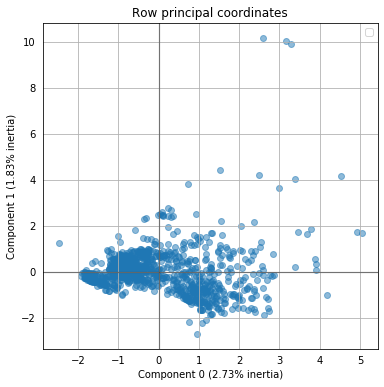

<IPython.core.display.Javascript object>

In [11]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False,
)
plt.show()

In [12]:
famd_coords = famd.row_coordinates(scaled_X)

<IPython.core.display.Javascript object>

Just from the Factor Analysis, it appears there are at least two dense clusters, with some outliers. DBSCAN should perform excellentlly here.

### Calculate Gower Distance Matrix for Mixed Data

In [13]:
# gower_dist = gower.gower_matrix(sample, cat_features=is_cat)
# gower_df = pd.DataFrame(gower_dist, columns=sample.index, index=sample.index)
# gower_df.head()

<IPython.core.display.Javascript object>

### K-Medoids

In [14]:
k = 2
nrows = gower_df.shape[0]
init_medoids = np.random.randint(0, nrows, k)
init_medoids

array([529, 291])

<IPython.core.display.Javascript object>

In [15]:
kmed = kmedoids(
    gower_dist, initial_index_medoids=init_medoids, data_type="distance_matrix"
)

kmed.process()

<IPython.core.display.Javascript object>

In [16]:
labels = kmed.predict(gower_dist)
sample["label"] = labels
sample["label"].value_counts(normalize=True)

0    0.559
1    0.441
Name: label, dtype: float64

<IPython.core.display.Javascript object>

In [17]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,0,1
NoEmp,5.415027,5.229025
CreateJob,1.336315,4.158730
RetainedJob,5.686941,3.755102
DisbursementGross,75167.656530,163811.639456
Term_years,3.260883,5.664399
Disbr_year,2005.881932,2005.641723
percent_SBA,0.500000,0.739334
bank_size,32951.366726,10654.585034


<IPython.core.display.Javascript object>

In [18]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1
State,CA,CA
BankState,NC,CA
NewExist,0,1
RevLineCr,1.000000,0.000000
LowDoc,0.000000,0.000000
MIS_Status,1,1
twoDigNAICS,23,72
is_franchise,0.000000,0.000000
bank_out_of_state,0,0
UrbanRural_cleaned,0.000000,0.000000


<IPython.core.display.Javascript object>

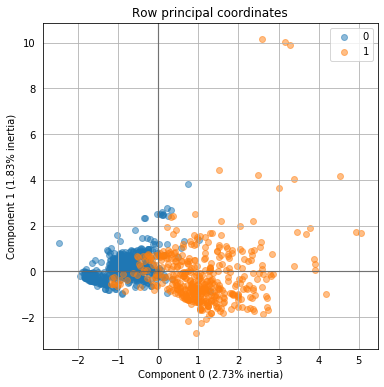

<IPython.core.display.Javascript object>

In [19]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False, color_labels=sample["label"],
)
plt.show()

### DBSCAN

In [20]:
clst = DBSCAN(eps=0.08, min_samples=20, metric="precomputed")
clst.fit(gower_df)

DBSCAN(algorithm='auto', eps=0.08, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

<IPython.core.display.Javascript object>

In [21]:
sample["label"] = clst.labels_
sample["label"].value_counts()

-1    906
 0     94
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [22]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,-1,0
NoEmp,5.422737,4.468085
CreateJob,2.790287,0.563830
RetainedJob,4.897351,4.234043
DisbursementGross,119447.635762,64256.329787
Term_years,4.403790,3.521277
Disbr_year,2005.827815,2005.276596
percent_SBA,0.616497,0.500000
bank_size,18876.086093,64008.000000


<IPython.core.display.Javascript object>

In [23]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,-1,0
State,CA,['CA' 'FL']
BankState,CA,NC
NewExist,0,0
RevLineCr,0.000000,1.000000
LowDoc,0.000000,0.000000
MIS_Status,1,1
twoDigNAICS,44,54
is_franchise,0.000000,0.000000
bank_out_of_state,0,0
UrbanRural_cleaned,0.000000,0.000000


<IPython.core.display.Javascript object>

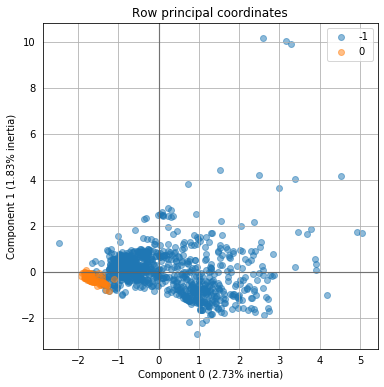

<IPython.core.display.Javascript object>

In [24]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False, color_labels=sample["label"],
)
plt.show()

### Hierarchical

In [31]:
clst = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="complete")
clst.fit(gower_df)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=2)

<IPython.core.display.Javascript object>

In [32]:
sample["label"] = clst.labels_
sample["label"].value_counts()

0    513
1    487
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [34]:
num_cols_labels = num_cols.copy()
num_cols_labels.append("label")
clst_avg = sample[num_cols_labels].groupby("label").mean().T
clst_avg.style.background_gradient(axis=1)

label,0,1
NoEmp,5.575049,5.078029
CreateJob,2.682261,2.474333
RetainedJob,4.153996,5.552361
DisbursementGross,152539.417154,73936.205339
Term_years,5.259259,3.332307
Disbr_year,2005.653021,2005.905544
percent_SBA,0.703209,0.502669
bank_size,10932.132554,35955.445585


<IPython.core.display.Javascript object>

In [35]:
cat_cols_labels = cat_cols.copy()
cat_cols_labels.append("label")
clst_avg = sample[cat_cols_labels].groupby("label").agg(pd.Series.mode).T
clst_avg.style.background_gradient(axis=1)

label,0,1
State,CA,CA
BankState,CA,NC
NewExist,0,0
RevLineCr,0.000000,1.000000
LowDoc,0.000000,0.000000
MIS_Status,1,1
twoDigNAICS,72,23
is_franchise,0.000000,0.000000
bank_out_of_state,0,0
UrbanRural_cleaned,0.000000,0.000000


<IPython.core.display.Javascript object>

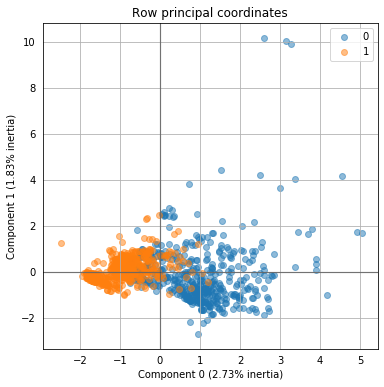

<IPython.core.display.Javascript object>

In [33]:
famd.plot_row_coordinates(
    scaled_X, alpha=0.5, ellipse_fill=False, color_labels=sample["label"],
)
plt.show()